### Preamble

In [1]:
#################################################################
### This is for custom test cases for the PC algorithms
### Using the causal-learn package in a Juypiter notebook
#################################################################

### Install the relevant packages beforehand, including the causallearn package
import os, time
import sys
sys.path.append("")
import unittest
import hashlib
import numpy as np
from causallearn.search.ConstraintBased.PC import pc
from causallearn.utils.cit import chisq, fisherz, gsq, kci, mv_fisherz, d_separation
from causallearn.utils.cit import CIT
from causallearn.graph.SHD import SHD
from causallearn.utils.DAG2CPDAG import dag2cpdag
from causallearn.utils.TXT2GeneralGraph import txt2generalgraph
from causallearn.utils.Dataset import load_dataset
from causallearn.utils.GraphUtils import GraphUtils
from causallearn.graph.ArrowConfusion import ArrowConfusion
from causallearn.graph.AdjacencyConfusion import AdjacencyConfusion
import pandas as pd

# Other stuff to install:
# 1. https://graphviz.org/download/ and this to the system PATH when you are installing graphviz.


### Simulation IA: Comparing different types of CI test on Sach Data

In [64]:
data, labels = load_dataset("sachs")
df = pd.DataFrame(np.array(data),columns=labels)

# ------------------------------------------------------------------
# 3.  Standardise (zero mean, unit variance) column‑wise
# ------------------------------------------------------------------
df_std = (df - df.mean()) / df.std(ddof=0)
data = df_std.to_numpy(dtype=float)  # Convert the DataFrame to a NumPy array
# df_std is your z‑scored DataFrame
print(df_std.iloc[0:5, :])  # Print the first 5 rows and columns of the z‑scored DataFrame
print(data.shape) # (number of samples, number of variables)
print(labels)  # Labels of the variables


        raf       mek       plc      pip2      pip3       erk       akt  \
0 -0.394616 -0.350584 -0.264792 -0.443731  0.737945 -0.436918 -0.465800   
1 -0.356234 -0.341831 -0.244775 -0.448742 -0.439188 -0.175263 -0.353283   
2 -0.261289 -0.268628 -0.231545 -0.470791 -0.326051 -0.256007 -0.353283   
3 -0.206342 -0.165984 -0.182652 -0.459767 -0.598090 -0.453940 -0.503548   
4 -0.365122 -0.333079 -0.285673 -0.472361 -0.051921 -0.120706 -0.254559   

        pka       pkc       p38       jnk  
0 -0.328605 -0.143669 -0.182147 -0.154269  
1 -0.424816 -0.290443 -0.239551 -0.054569  
2 -0.345675 -0.203972 -0.208423 -0.249332  
3 -0.151701 -0.179205 -0.215094 -0.232638  
4 -0.497751 -0.276552 -0.220955  0.037248  
(7466, 11)
['raf', 'mek', 'plc', 'pip2', 'pip3', 'erk', 'akt', 'pka', 'pkc', 'p38', 'jnk']


#### CI Test: FisherZ

  0%|          | 0/11 [00:00<?, ?it/s]


 PC test using FisherZ completed.

 Computational Time Elapsed:  0.2853439000318758  seconds


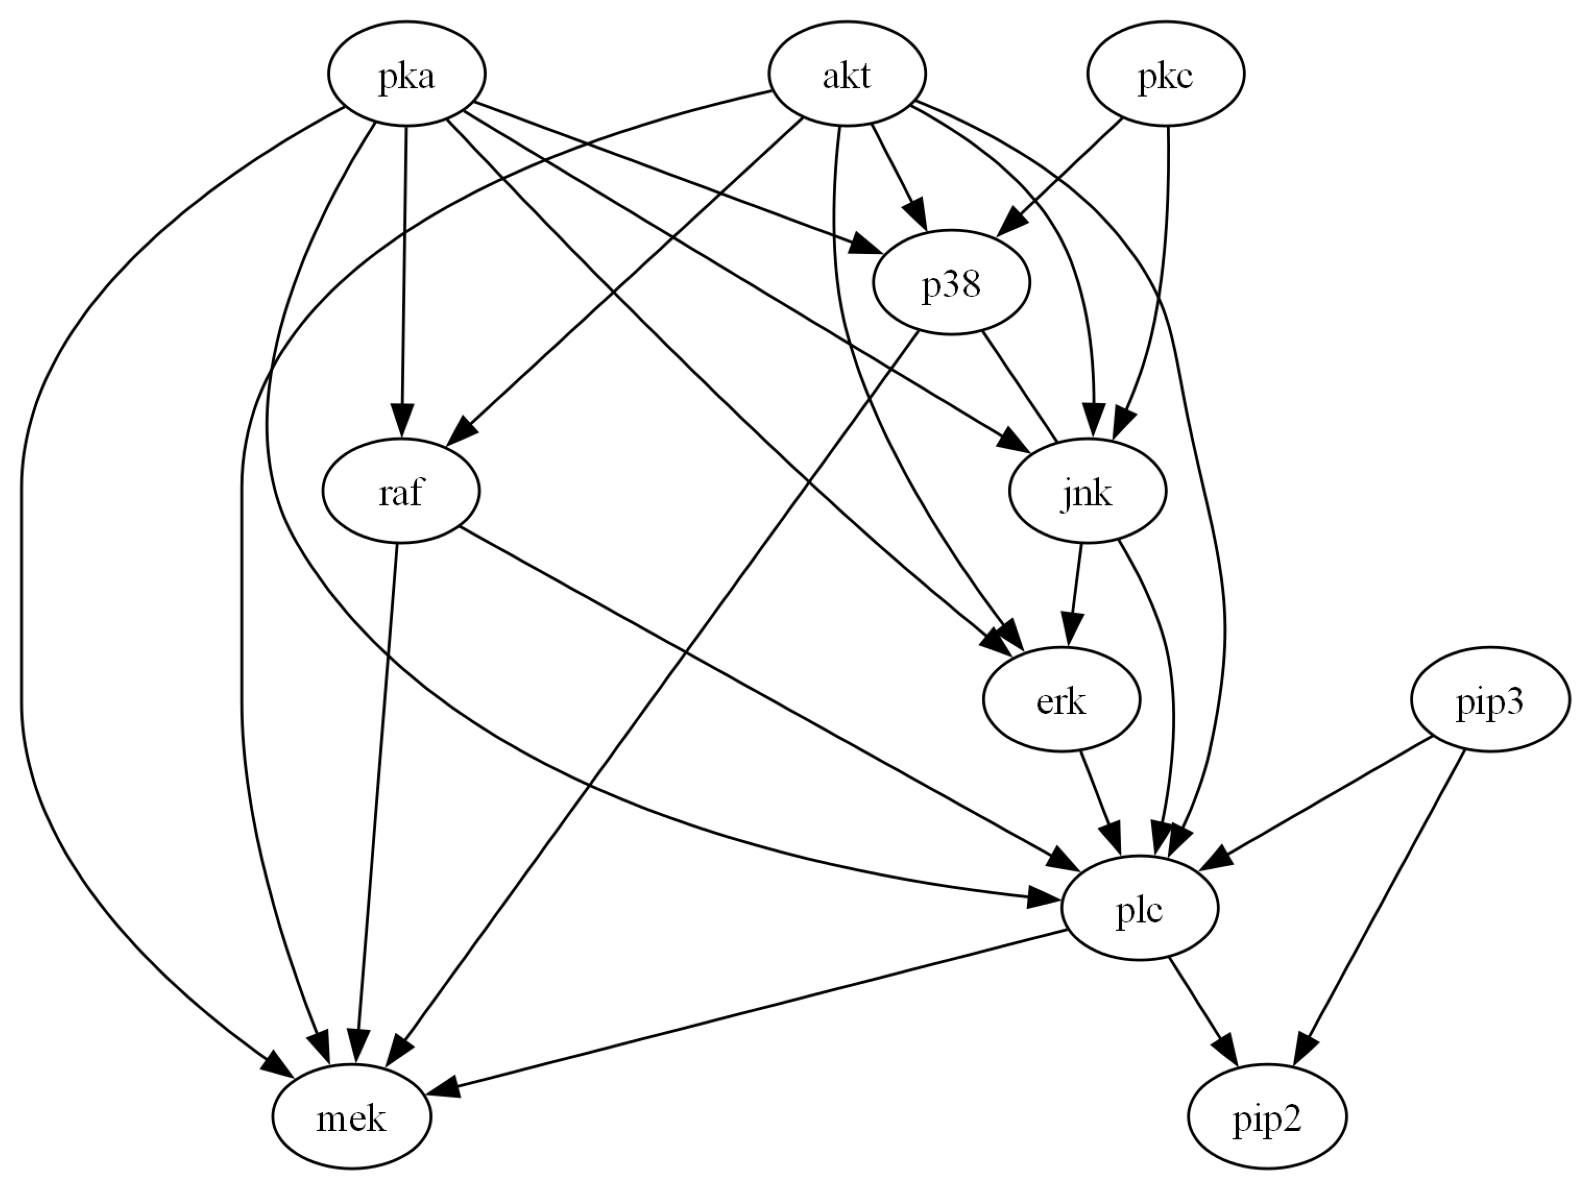

In [65]:
# Run the PC algorithm with different parameters
start_time = time.monotonic()
cg_fisherz = pc(data,
        alpha = 0.05,
        indep_test = "fisherz",
        # parameters for the indep_test
        # end 
        stable = True,
        uc_rule = 0,
        uc_priority = 2,
        mvpc = False,
        correction_name = None,
        background_knowledge = None,  # A way to add background knowledge
        verbose = False,
        show_progress = True
)
print("\n PC test using FisherZ completed.")
end_time = time.monotonic()
print("\n Computational Time Elapsed: ", end_time - start_time, " seconds" )


# Visualize using pydot and save the graph
cg_fisherz.draw_pydot_graph(labels=labels)
pyd_fisherz = GraphUtils.to_pydot(cg_fisherz.G, labels=labels)
pyd_fisherz.write_png('sach_fisherz.png')

# Metrics



In [66]:
# For arrows

est = cg_fisherz.G
truth_cpdag = txt2generalgraph("tests/TestData/bnlearn_discrete_10000/truth_dag_graph/sachs.graph.txt")

adj   = AdjacencyConfusion(truth_cpdag, est)
arrow = ArrowConfusion(truth_cpdag, est)

arrow_stats = {
    "TP"       : arrow.get_arrows_tp(),
    "FP"       : arrow.get_arrows_fp(),
    "FN"       : arrow.get_arrows_fn(),
    #"TN"       : arrow.get_arrows_tn(),
    "Precision": round(arrow.get_arrows_precision(), 3),
    "Recall"   : round(arrow.get_arrows_recall(),    3),
    "F1"       : round(arrow.get_arrows_f1(),        3),
}

adj_stats = {
    "TP"       : adj.get_adj_tp(),
    "FP"       : adj.get_adj_fp(),
    "FN"       : adj.get_adj_fn(),
    #"TN"       : adj.get_adj_tn(),
    "Precision": round(adj.get_adj_precision(), 3),
    "Recall"   : round(adj.get_adj_recall(),    3),
    "F1"       : round(adj.get_adj_f1(),        3),
}

df = pd.DataFrame(
    [adj_stats, arrow_stats], 
    index=["Adjacency", "Arrow‑head"]
).T

#display(df.style.set_sticky()) 
display(df) 

# Structural Hamming Distance
shd = SHD(truth_cpdag, est).get_shd()
print("Structural Hamming Distance:", shd)

,Adjacency,Arrow‑head
TP,8.000,6.000
FP,17.000,18.000
FN,9.000,11.000
Precision,0.320,0.250
Recall,0.471,0.353
F1,0.381,0.293


Structural Hamming Distance: 28


#### CI Test: RCIT

In [ ]:
# Run the PC algorithm with different parameters
start_time = time.monotonic()
cg_rcit = pc(data,
        alpha = 0.05,
        indep_test = "rcit",
        # parameters for the indep_test
        n_components = 1000, # number of components for the RCIT test, <= number of samples
        # end
        cache_path= "cache/sachs_rcit_cache.json", # caching helps
        stable = True,  
        uc_rule = 0,
        uc_priority = 2,
        mvpc = False,
        correction_name = None,
        background_knowledge = None,  # A way to add background knowledge
        verbose = True,
        show_progress = True,
)
print("\n PC test using RCIT completed.")
end_time = time.monotonic()
print("\n Computational Time Elapsed: ", end_time - start_time, " seconds" )


# Visualize using pydot and save the graph
cg_rcit.draw_pydot_graph(labels=labels)
pyd_rcit = GraphUtils.to_pydot(cg_rcit.G, labels=labels)
pyd_rcit.write_png('sach_rcit.png')

# Visualize using networks
# cg_fisherz.to_nx_graph()
# cg_fisherz.draw_nx_graph(skel=False)



  0%|          | 0/11 [00:00<?, ?it/s]

0 dep 1 | () with p-value 0.000000

0 dep 2 | () with p-value 0.000000

0 dep 3 | () with p-value 0.000000

0 dep 4 | () with p-value 0.000000

0 dep 5 | () with p-value 0.000000

0 dep 6 | () with p-value 0.000000

0 dep 7 | () with p-value 0.000000

0 dep 8 | () with p-value 0.000000

0 dep 9 | () with p-value 0.000000

0 dep 10 | () with p-value 0.000000

1 dep 0 | () with p-value 0.000000

1 dep 2 | () with p-value 0.000000

1 dep 3 | () with p-value 0.000000

1 dep 4 | () with p-value 0.000000

1 dep 5 | () with p-value 0.016676

1 dep 6 | () with p-value 0.000000

1 dep 7 | () with p-value 0.000000

1 dep 8 | () with p-value 0.000000

1 dep 9 | () with p-value 0.000000

1 dep 10 | () with p-value 0.000000

2 dep 0 | () with p-value 0.000000

2 dep 1 | () with p-value 0.000000

2 dep 3 | () with p-value 0.000000

2 dep 4 | () with p-value 0.000000

2 dep 5 | () with p-value 0.000000

2 dep 6 | () with p-value 0.000000

2 dep 7 | () with p-value 0.000000

2 dep 8 | () with p-value 

In [ ]:
# For arrows

est = cg_rcit.G
truth_cpdag = txt2generalgraph("tests/TestData/bnlearn_discrete_10000/truth_dag_graph/sachs.graph.txt")

adj   = AdjacencyConfusion(truth_cpdag, est)
arrow = ArrowConfusion(truth_cpdag, est)

print(adj)

arrow_stats = {
    "TP"       : arrow.get_arrows_tp(),
    "FP"       : arrow.get_arrows_fp(),
    "FN"       : arrow.get_arrows_fn(),
    #"TN"       : arrow.get_arrows_tn(),
    "Precision": round(arrow.get_arrows_precision(), 3),
    "Recall"   : round(arrow.get_arrows_recall(),    3),
    "F1"       : round(arrow.get_arrows_f1(),        3),
}

adj_stats = {
    "TP"       : adj.get_adj_tp(),
    "FP"       : adj.get_adj_fp(),
    "FN"       : adj.get_adj_fn(),
    #"TN"       : adj.get_adj_tn(),
    "Precision": round(adj.get_adj_precision(), 3),
    "Recall"   : round(adj.get_adj_recall(),    3),
    "F1"       : round(adj.get_adj_f1(),        3),
}

df = pd.DataFrame(
    [adj_stats, arrow_stats], 
    index=["Adjacency", "Arrow‑head"]
).T

#display(df.style.set_sticky()) 
display(df) 

# Structural Hamming Distance
shd = SHD(truth_cpdag, est).get_shd()
print("Structural Hamming Distance:", shd)

,Adjacency,Arrow‑head
TP,6.000,1.000
FP,11.000,13.000
FN,11.000,16.000
Precision,0.353,0.071
Recall,0.353,0.059
F1,0.353,0.065


Structural Hamming Distance: 27


#### CI Test: Fast KCI (Too Time Consuming)

In [ ]:
# Run the PC algorithm with different parameters
start_time = time.monotonic()
cg_fastkci = pc(data,
        alpha = 0.05,
        indep_test = "fastkci",
        # parameters for the indep_test
        n_components = 500, # number of components for the RCOT test, <= number of samples
        approx = True,
        kernelZ = "Linear",
        n_jobs = 4, # number of parallel jobs; - 1 if you want to use all processors
        # end
        cache_path= "cache/sachs_fastkci_cache.json", # caching helps
        stable = True,  
        uc_rule = 0,
        uc_priority = 2,
        mvpc = False,
        correction_name = None,
        background_knowledge = None,  # A way to add background knowledge
        verbose = True,
        show_progress = True,
)
print("\n PC test using FastKCI completed.")
end_time = time.monotonic()
print("\n Computational Time Elapsed: ", end_time - start_time, " seconds" )


# Visualize using pydot and save the graph
cg_fastkci.draw_pydot_graph(labels=labels)
pyd_fastkci = GraphUtils.to_pydot(cg_fastkci.G, labels=labels)
pyd_fastkci.write_png('sach_fastkci.png')

# Visualize using networks
# cg_fisherz.to_nx_graph()
# cg_fisherz.draw_nx_graph(skel=False)


  0%|          | 0/11 [00:00<?, ?it/s]

0 dep 1 | () with p-value 0.000000

0 dep 2 | () with p-value 0.000000



KeyboardInterrupt: 

### Simulation IB: Comparing different types of CI test on Binned Sach Data

In [54]:
data, labels = load_dataset("sachs")
data = np.loadtxt('tests/TestData/bnlearn_discrete_10000/data/sachs.txt', skiprows=1)
df = pd.DataFrame(np.array(data),columns=labels)

# ------------------------------------------------------------------
# 3.  Standardise (zero mean, unit variance) column‑wise
# ------------------------------------------------------------------
#df_std = (df - df.mean()) / df.std(ddof=0)
#data = df_std.to_numpy(dtype=float)  # Convert the DataFrame to a NumPy array
# df_std is your z‑scored DataFrame
print(df_std.iloc[0:5, :])  # Print the first 5 rows and columns of the z‑scored DataFrame
print(data.shape) # (number of samples, number of variables)
print(labels)  # Labels of the variables


        raf       mek       plc      pip2      pip3       erk       akt  \
0  0.758365 -0.733996  0.870178  0.810922  0.561029  0.403711 -1.012840   
1  0.758365 -0.733996  0.870178  0.810922  0.561029  0.403711  1.529110   
2  0.758365 -0.733996  0.870178  0.810922  0.561029  0.403711  1.529110   
3  0.758365 -0.733996  0.870178  0.810922 -2.142724  0.403711  0.258135   
4  0.758365 -0.733996 -0.186889 -1.396270  0.561029  0.403711 -1.012840   

        pka       pkc       p38       jnk  
0 -0.619304 -0.985286  0.442737  0.907874  
1 -0.619304 -0.985286 -1.219814  0.907874  
2 -0.619304 -0.985286  0.442737  0.907874  
3  0.634856  1.123856  0.442737  0.907874  
4 -0.619304  0.069285  0.442737 -1.404297  
(10000, 11)
['raf', 'mek', 'plc', 'pip2', 'pip3', 'erk', 'akt', 'pka', 'pkc', 'p38', 'jnk']


#### CI Test: FisherZ

  0%|          | 0/11 [00:00<?, ?it/s]


 PC test using FisherZ completed.

 Computational Time Elapsed:  0.18279329995857552  seconds


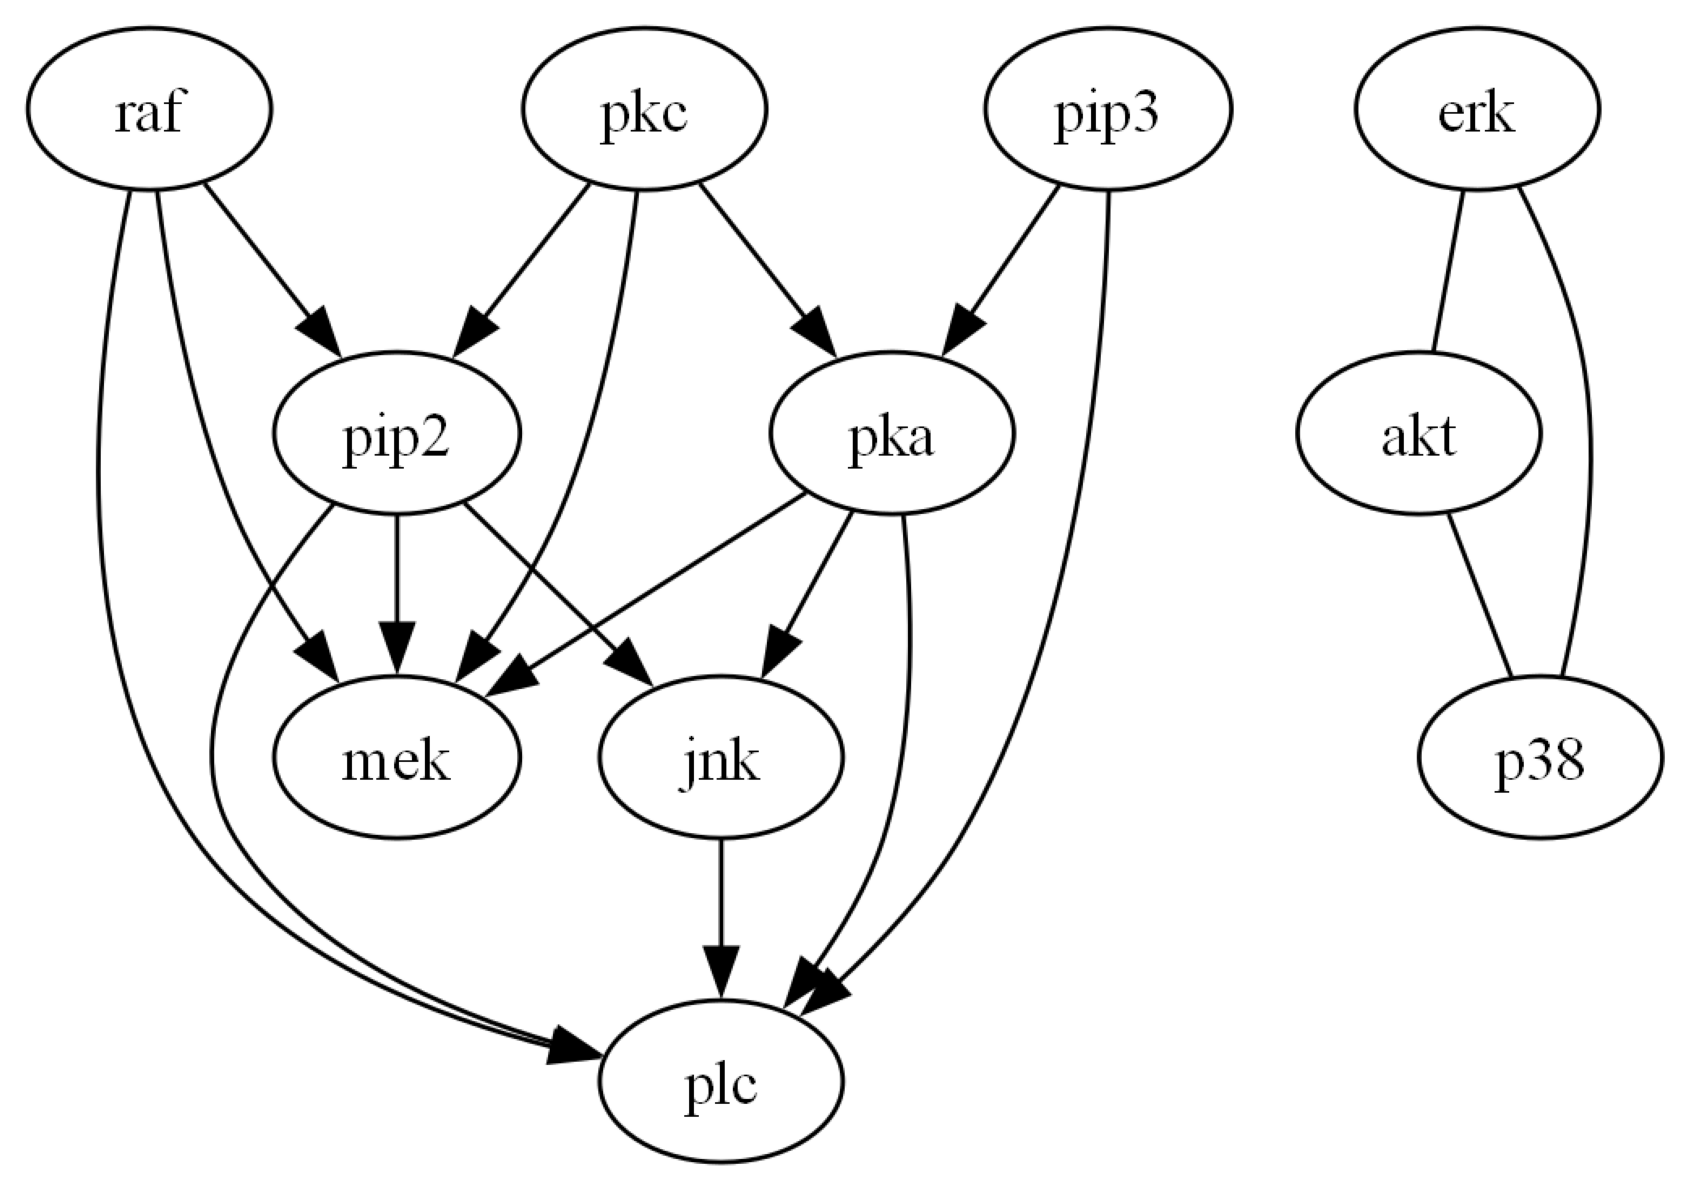

In [ ]:
# Run the PC algorithm with different parameters
start_time = time.monotonic()
cg_fisherz = pc(data,
        alpha = 0.05,
        indep_test = "fisherz",
        # parameters for the indep_test
        # end 
        stable = True,
        uc_rule = 0,
        uc_priority = 2,
        mvpc = False,
        correction_name = None,
        background_knowledge = None,  # A way to add background knowledge
        verbose = False,
        show_progress = True
)
print("\n PC test using FisherZ completed.")
end_time = time.monotonic()
print("\n Computational Time Elapsed: ", end_time - start_time, " seconds" )


# Visualize using pydot and save the graph
cg_fisherz.draw_pydot_graph(labels=labels)
pyd_fisherz = GraphUtils.to_pydot(cg_fisherz.G, labels=labels)
pyd_fisherz.write_png('sach_fisherz_binned.png')

# Metrics



In [56]:
# For arrows

est = cg_fisherz.G
truth_cpdag = txt2generalgraph("tests/TestData/bnlearn_discrete_10000/truth_dag_graph/sachs.graph.txt")

adj   = AdjacencyConfusion(truth_cpdag, est)
arrow = ArrowConfusion(truth_cpdag, est)

arrow_stats = {
    "TP"       : arrow.get_arrows_tp(),
    "FP"       : arrow.get_arrows_fp(),
    "FN"       : arrow.get_arrows_fn(),
    #"TN"       : arrow.get_arrows_tn(),
    "Precision": round(arrow.get_arrows_precision(), 3),
    "Recall"   : round(arrow.get_arrows_recall(),    3),
    "F1"       : round(arrow.get_arrows_f1(),        3),
}

adj_stats = {
    "TP"       : adj.get_adj_tp(),
    "FP"       : adj.get_adj_fp(),
    "FN"       : adj.get_adj_fn(),
    #"TN"       : adj.get_adj_tn(),
    "Precision": round(adj.get_adj_precision(), 3),
    "Recall"   : round(adj.get_adj_recall(),    3),
    "F1"       : round(adj.get_adj_f1(),        3),
}

df = pd.DataFrame(
    [adj_stats, arrow_stats], 
    index=["Adjacency", "Arrow‑head"]
).T

#display(df.style.set_sticky()) 
display(df) 

# Structural Hamming Distance
shd = SHD(truth_cpdag, est).get_shd()
print("Structural Hamming Distance:", shd)

,Adjacency,Arrow‑head
TP,12.000,6.000
FP,6.000,9.000
FN,5.000,11.000
Precision,0.667,0.400
Recall,0.706,0.353
F1,0.686,0.375


Structural Hamming Distance: 17


#### CI Test: Chi-Squared

  0%|          | 0/11 [00:00<?, ?it/s]


 PC test using FisherZ completed.

 Computational Time Elapsed:  0.6236375999869779  seconds


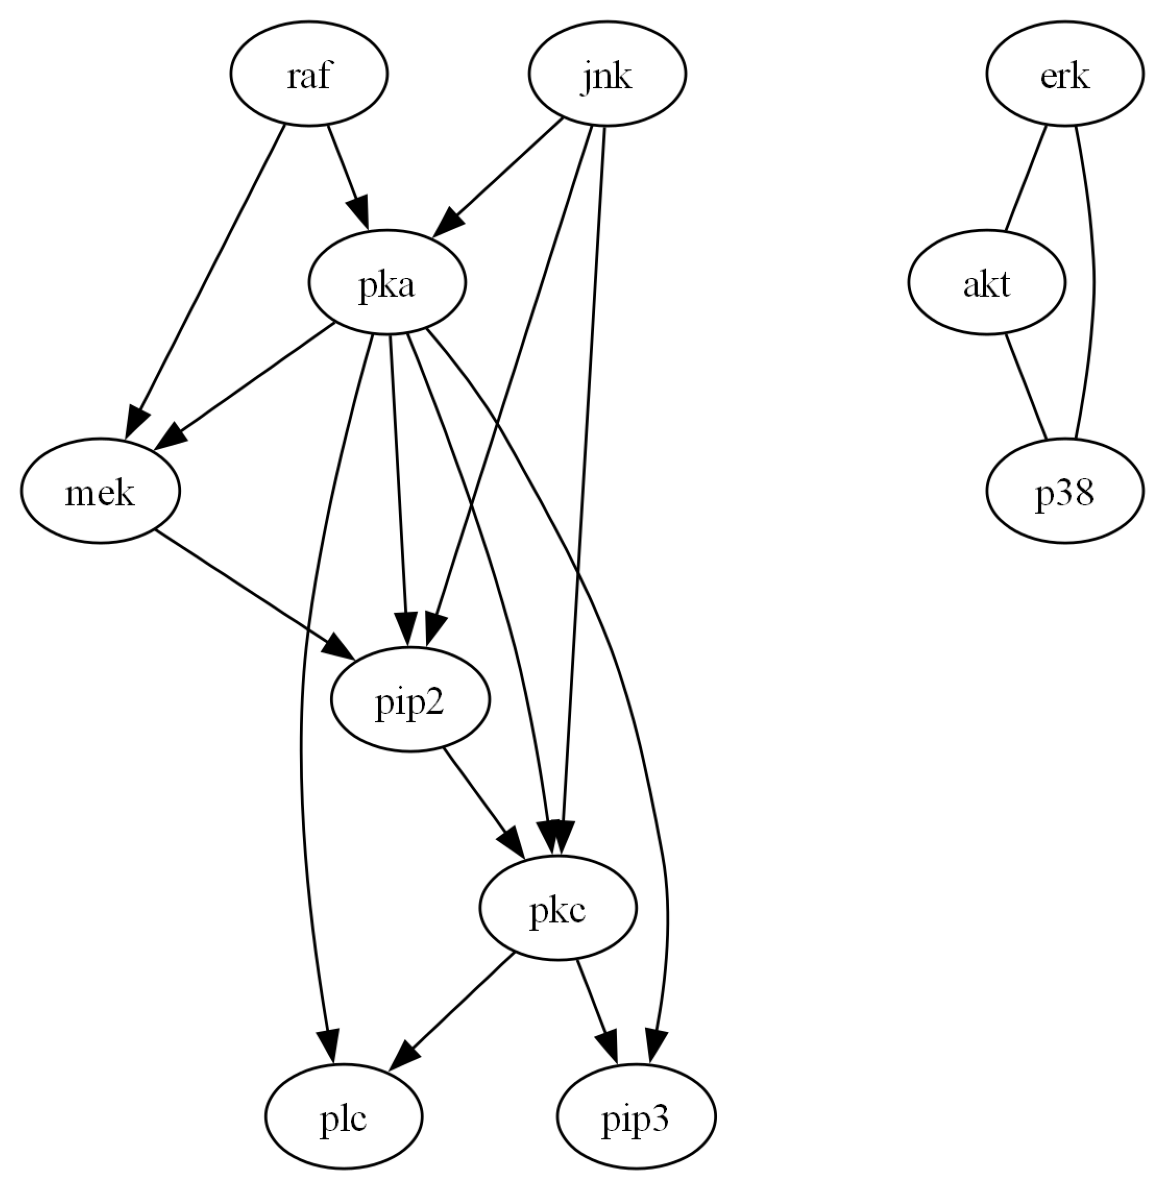

In [ ]:
# Run the PC algorithm with different parameters
start_time = time.monotonic()
cg_chisq = pc(data,
        alpha = 0.05,
        indep_test = "chisq",
        # parameters for the indep_test
        # end 
        stable = True,
        uc_rule = 0,
        uc_priority = 2,
        mvpc = False,
        correction_name = None,
        background_knowledge = None,  # A way to add background knowledge
        verbose = False,
        show_progress = True
)
print("\n PC test using chisq completed.")
end_time = time.monotonic()
print("\n Computational Time Elapsed: ", end_time - start_time, " seconds" )


# Visualize using pydot and save the graph
cg_chisq.draw_pydot_graph(labels=labels)
pyd_chisq = GraphUtils.to_pydot(cg_chisq.G, labels=labels)
pyd_chisq.write_png('sach_chisq_binned.png')



In [58]:
# For arrows

est = cg_chisq.G
truth_cpdag = txt2generalgraph("tests/TestData/bnlearn_discrete_10000/truth_dag_graph/sachs.graph.txt")

adj   = AdjacencyConfusion(truth_cpdag, est)
arrow = ArrowConfusion(truth_cpdag, est)

arrow_stats = {
    "TP"       : arrow.get_arrows_tp(),
    "FP"       : arrow.get_arrows_fp(),
    "FN"       : arrow.get_arrows_fn(),
    #"TN"       : arrow.get_arrows_tn(),
    "Precision": round(arrow.get_arrows_precision(), 3),
    "Recall"   : round(arrow.get_arrows_recall(),    3),
    "F1"       : round(arrow.get_arrows_f1(),        3),
}

adj_stats = {
    "TP"       : adj.get_adj_tp(),
    "FP"       : adj.get_adj_fp(),
    "FN"       : adj.get_adj_fn(),
    #"TN"       : adj.get_adj_tn(),
    "Precision": round(adj.get_adj_precision(), 3),
    "Recall"   : round(adj.get_adj_recall(),    3),
    "F1"       : round(adj.get_adj_f1(),        3),
}

df = pd.DataFrame(
    [adj_stats, arrow_stats], 
    index=["Adjacency", "Arrow‑head"]
).T

#display(df.style.set_sticky()) 
display(df) 

# Structural Hamming Distance
shd = SHD(truth_cpdag, est).get_shd()
print("Structural Hamming Distance:", shd)

,Adjacency,Arrow‑head
TP,17.0,7.000
FP,0.0,7.000
FN,0.0,10.000
Precision,1.0,0.500
Recall,1.0,0.412
F1,1.0,0.452


Structural Hamming Distance: 10


#### CI Test: G-Squared

  0%|          | 0/11 [00:00<?, ?it/s]


 PC test using gsq completed.

 Computational Time Elapsed:  0.6337379000033252  seconds


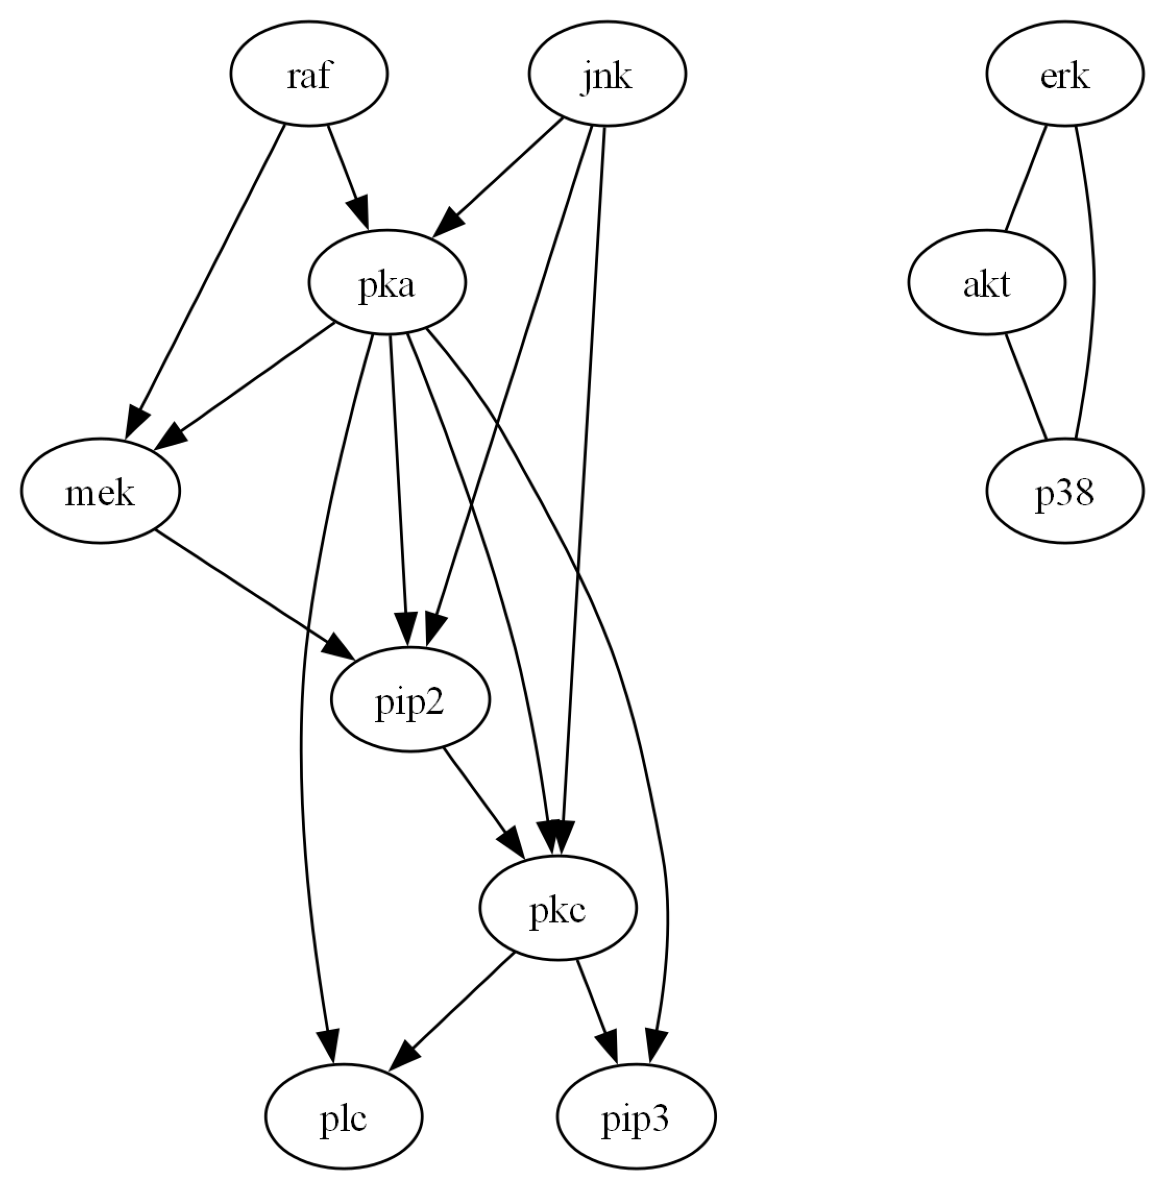

In [ ]:
# Run the PC algorithm with different parameters
start_time = time.monotonic()
cg_gsq = pc(data,
        alpha = 0.05,
        indep_test = "gsq",
        # parameters for the indep_test
        # end 
        stable = True,
        uc_rule = 0,
        uc_priority = 2,
        mvpc = False,
        correction_name = None,
        background_knowledge = None,  # A way to add background knowledge
        verbose = False,
        show_progress = True
)
print("\n PC test using gsq completed.")
end_time = time.monotonic()
print("\n Computational Time Elapsed: ", end_time - start_time, " seconds" )


# Visualize using pydot and save the graph
cg_gsq.draw_pydot_graph(labels=labels)
pyd_gsq = GraphUtils.to_pydot(cg_gsq.G, labels=labels)
pyd_gsq.write_png('sach_gsq_binned.png')



In [61]:
# For arrows

est = cg_gsq.G
truth_cpdag = txt2generalgraph("tests/TestData/bnlearn_discrete_10000/truth_dag_graph/sachs.graph.txt")

adj   = AdjacencyConfusion(truth_cpdag, est)
arrow = ArrowConfusion(truth_cpdag, est)

arrow_stats = {
    "TP"       : arrow.get_arrows_tp(),
    "FP"       : arrow.get_arrows_fp(),
    "FN"       : arrow.get_arrows_fn(),
    #"TN"       : arrow.get_arrows_tn(),
    "Precision": round(arrow.get_arrows_precision(), 3),
    "Recall"   : round(arrow.get_arrows_recall(),    3),
    "F1"       : round(arrow.get_arrows_f1(),        3),
}

adj_stats = {
    "TP"       : adj.get_adj_tp(),
    "FP"       : adj.get_adj_fp(),
    "FN"       : adj.get_adj_fn(),
    #"TN"       : adj.get_adj_tn(),
    "Precision": round(adj.get_adj_precision(), 3),
    "Recall"   : round(adj.get_adj_recall(),    3),
    "F1"       : round(adj.get_adj_f1(),        3),
}

df = pd.DataFrame(
    [adj_stats, arrow_stats], 
    index=["Adjacency", "Arrow‑head"]
).T

#display(df.style.set_sticky()) 
display(df) 

# Structural Hamming Distance
shd = SHD(truth_cpdag, est).get_shd()
print("Structural Hamming Distance:", shd)

,Adjacency,Arrow‑head
TP,17.0,7.000
FP,0.0,7.000
FN,0.0,10.000
Precision,1.0,0.500
Recall,1.0,0.412
F1,1.0,0.452


Structural Hamming Distance: 10


#### CI Test: RCIT

  0%|          | 0/11 [00:00<?, ?it/s]

0 dep 1 | () with p-value 0.000000

0 dep 2 | () with p-value 0.000001

0 dep 3 | () with p-value 0.000000

0 dep 4 | () with p-value 0.000000

0 ind 5 | () with p-value 1.000000

0 ind 6 | () with p-value 0.400188

0 dep 7 | () with p-value 0.000000

0 dep 8 | () with p-value 0.003368

0 ind 9 | () with p-value 0.164334

0 dep 10 | () with p-value 0.000001

1 dep 0 | () with p-value 0.000000

1 dep 2 | () with p-value 0.028079

1 dep 3 | () with p-value 0.000000

1 dep 4 | () with p-value 0.000000

1 ind 5 | () with p-value 0.237968

1 ind 6 | () with p-value 0.124581

1 dep 7 | () with p-value 0.000000

1 dep 8 | () with p-value 0.000000

1 ind 9 | () with p-value 0.642038

1 dep 10 | () with p-value 0.000000

2 dep 0 | () with p-value 0.000001

2 dep 1 | () with p-value 0.028079

2 dep 3 | () with p-value 0.000142

2 dep 4 | () with p-value 0.033748

2 ind 5 | () with p-value 0.527379

2 ind 6 | () with p-value 0.449363

2 dep 7 | () with p-value 0.000000

2 dep 8 | () with p-value 

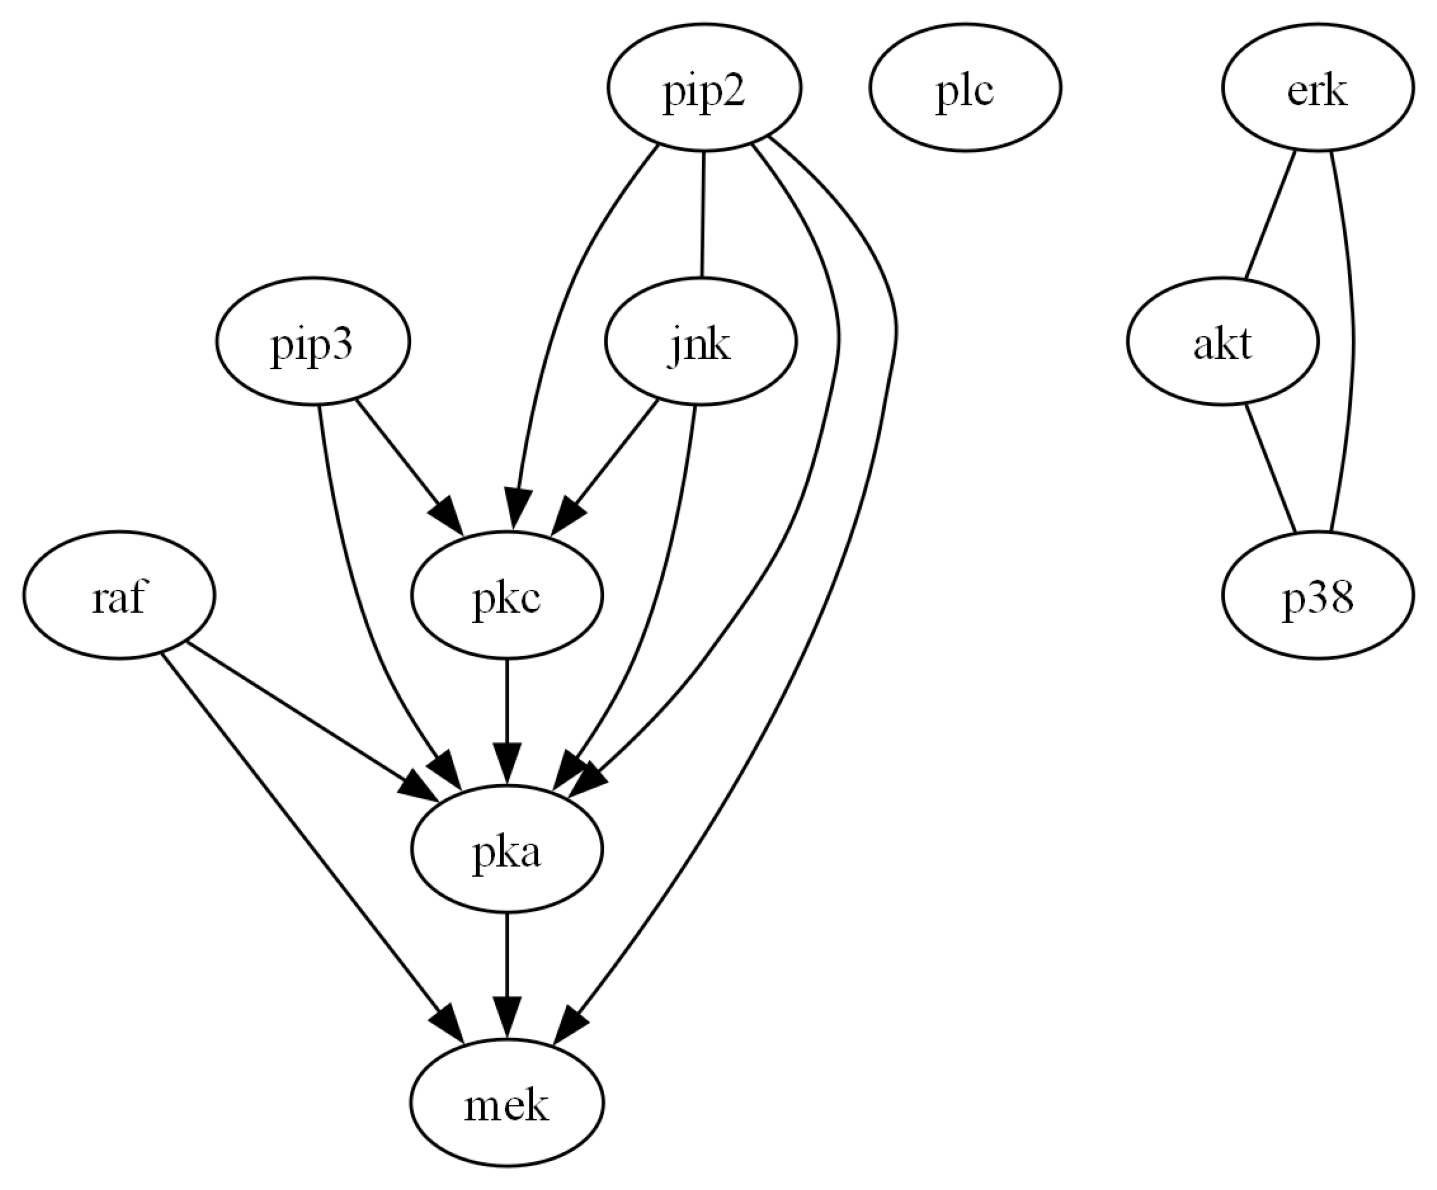

In [ ]:
# Run the PC algorithm with different parameters
start_time = time.monotonic()
cg_rcit = pc(data,
        alpha = 0.05,
        indep_test = "rcit",
        # parameters for the indep_test
        n_components = 1000, # number of components for the RCIT test, <= number of samples
        # end
        cache_path= "cache/sachs_rcit_binned_cache.json", # caching helps
        stable = True,  
        uc_rule = 0,
        uc_priority = 2,
        mvpc = False,
        correction_name = None,
        background_knowledge = None,  # A way to add background knowledge
        verbose = True,
        show_progress = True,
)
print("\n PC test using RCIT completed.")
end_time = time.monotonic()
print("\n Computational Time Elapsed: ", end_time - start_time, " seconds" )


# Visualize using pydot and save the graph
cg_rcit.draw_pydot_graph(labels=labels)
pyd_rcit = GraphUtils.to_pydot(cg_rcit.G, labels=labels)
pyd_rcit.write_png('sach_rcit_binned.png')

# Visualize using networks
# cg_fisherz.to_nx_graph()
# cg_fisherz.draw_nx_graph(skel=False)



In [63]:
# For arrows

est = cg_rcit.G
truth_cpdag = txt2generalgraph("tests/TestData/bnlearn_discrete_10000/truth_dag_graph/sachs.graph.txt")

adj   = AdjacencyConfusion(truth_cpdag, est)
arrow = ArrowConfusion(truth_cpdag, est)

print(adj)

arrow_stats = {
    "TP"       : arrow.get_arrows_tp(),
    "FP"       : arrow.get_arrows_fp(),
    "FN"       : arrow.get_arrows_fn(),
    #"TN"       : arrow.get_arrows_tn(),
    "Precision": round(arrow.get_arrows_precision(), 3),
    "Recall"   : round(arrow.get_arrows_recall(),    3),
    "F1"       : round(arrow.get_arrows_f1(),        3),
}

adj_stats = {
    "TP"       : adj.get_adj_tp(),
    "FP"       : adj.get_adj_fp(),
    "FN"       : adj.get_adj_fn(),
    #"TN"       : adj.get_adj_tn(),
    "Precision": round(adj.get_adj_precision(), 3),
    "Recall"   : round(adj.get_adj_recall(),    3),
    "F1"       : round(adj.get_adj_f1(),        3),
}

df = pd.DataFrame(
    [adj_stats, arrow_stats], 
    index=["Adjacency", "Arrow‑head"]
).T

#display(df.style.set_sticky()) 
display(df) 

# Structural Hamming Distance
shd = SHD(truth_cpdag, est).get_shd()
print("Structural Hamming Distance:", shd)

,Adjacency,Arrow‑head
TP,15.000,3.000
FP,0.000,8.000
FN,2.000,14.000
Precision,1.000,0.273
Recall,0.882,0.176
F1,0.938,0.214


Structural Hamming Distance: 14
